# Mean speed cycle activity 

In this notebook we will be predicting the mean speed of cycle activities. for this we several variables of a cycle activity dataset from Strava (activitie tracking app) and a weather dataset from the KNMI (Koninklijk Nederlands Metrologisch Instituut).

In [1323]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt 
import sklearn as sk
import math
import statsmodels.api as sm

# train and test data 
from sklearn.model_selection import train_test_split 

# regression models 
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# check preformance for regression 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

### Cleaning data

Load csv files

In [1324]:
weather = pd.read_csv('weather.csv',sep=';')#load csv file 
activities = pd.read_csv('activities_mart.csv', sep=';')#load csv file 

In [1325]:
weather['datetime'] = pd.to_datetime(weather['datetime'], format='%Y%m%d', errors='ignore')# change dutch to english date

weather['TN.1'] = weather['TN.1'].str.replace(',', '.')# change dutch to english punctuation

weather['TN.1']= weather['TN.1'].astype('float64')# convert into numerical 

weather['TX.1'] = weather['TX.1'].str.replace(',', '.')# change dutch to english punctuation

weather['TX.1'] = weather['TX.1'].astype('float64')# convert into numerical 


activities = activities.rename(columns={'Datum van activiteit': 'datetime'})# change column name 

activities["datetime"] = activities["datetime"].str.replace("jan.", "01")
activities["datetime"] = activities["datetime"].str.replace("feb.", "02")
activities["datetime"] = activities["datetime"].str.replace("mrt.", "03")
activities["datetime"] = activities["datetime"].str.replace("apr.", "04")
activities["datetime"] = activities["datetime"].str.replace("mei.", "05")    
activities["datetime"] = activities["datetime"].str.replace("jun.", "06")
activities["datetime"] = activities["datetime"].str.replace("jul.", "07")
activities["datetime"] = activities["datetime"].str.replace("aug.", "08")
activities["datetime"] = activities["datetime"].str.replace("sep.", "09")
activities["datetime"] = activities["datetime"].str.replace("okt.", "10")    
activities["datetime"] = activities["datetime"].str.replace("nov.", "11")
activities["datetime"] = activities["datetime"].str.replace("dec.", "12")

activities["datetime"] = activities["datetime"].str.replace("052019", "05 2019")
activities["datetime"] = activities["datetime"].str.replace("052020", "05 2020")

activities["datetime"] = pd.to_datetime(activities["datetime"], format="%d %m %Y %H:%M:%S")# change format of activity datetime

activities["datetime"] = pd.to_datetime(activities["datetime"]).dt.date


weather['datetime'] = weather['datetime'].astype('str')
activities["datetime"] = activities["datetime"].astype('str')

activity_date = []# create new list for dates

for date in activities['datetime']:# add dates for activities to list 
    activity_date.append(date)

weather = weather.loc[weather['datetime'].isin(activity_date)]# only select weather data for dates in activities

activities = activities.groupby(['datetime']).mean()# group by dattime and calculate mean of double dates in activities for merging

weather = weather.set_index(['datetime'])# set index to datetime for merging 

aw = pd.merge(activities, weather, on = 'datetime')# merge two dataframes on datetime 

aw = aw.reset_index().fillna(0)

aw = aw.drop(['Gewicht sporter', 'Gewicht fiets', 'Grootste hoogte', 'Forenzenrit', 'Verstreken tijd.1', 'Activiteits-ID', 'Hoogteverlies', 'Kleinste hoogte', 'Gemiddelde snelheid', 'Vergelijkbare poging', 'Gemiddeld stijgingspercentage', ' FHN', 'UX', 'TN', 'TX', 'Max. snelheid'], axis=1)

aw.columns = aw.columns.str.lstrip()# remove space in column name FHN 

aw['datetime'] = aw['datetime'].astype('datetime64[ns]')

aw = aw.rename(columns={'Afstand.1': 'Afstand', 'TN.1': 'Temp_min', 'TX.1': 'Temp_max', 'RH': 'Neerslag', 'datetime': 'Datetime'})

aw['Neerslag'] = aw['Neerslag'].astype('str')
aw['Neerslag'] = aw['Neerslag'].str.replace('-', '')
aw['Neerslag'] = aw['Neerslag'].astype('float64')

aw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Datetime                  159 non-null    datetime64[ns]
 1   Verstreken tijd           159 non-null    float64       
 2   Beweegtijd                159 non-null    float64       
 3   Afstand                   159 non-null    float64       
 4   Hoogteverschil            159 non-null    float64       
 5   Max. stijgingspercentage  159 non-null    float64       
 6   Neerslag                  159 non-null    float64       
 7   Temp_min                  159 non-null    float64       
 8   Temp_max                  159 non-null    float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 11.3 KB


Now some of the variable units need to be scaled:

- Astand is in meters. This needs to be divided by 1000.
- Verstreken tijd and Beweegtijd are in seconds. This needs to be divided by 3600.

By dividing these variables we can create the dependent variable Mean speed (Gem. snelheid). We can also create an extra variable Break (Pauze) by substracting Total time (Verstreken tijd) and Moving time (Beweegtijd). 

Before we can include the tempreture as an independent variable we first need to sum Temp_min and Temp_max and divide it by two.

In [1326]:
aw['Verstreken tijd, uur'] = aw['Verstreken tijd']/3600
aw['Beweegtijd, uur'] = aw['Beweegtijd']/3600
aw['Afstand'] = aw['Afstand']/1000
aw['Gem. snelheid'] = aw['Afstand']/aw['Beweegtijd, uur']
aw['Pauze'] = aw['Verstreken tijd, uur'] - aw['Beweegtijd, uur']
aw['Dag'] = aw['Datetime'].dt.day_name()
aw['Gem. temp'] = (aw['Temp_min'] + aw['Temp_max'])/2

After scaling we can subset the variables we need.

In [1327]:
df = aw[['Gem. temp', 'Dag', 'Pauze', 'Gem. snelheid', 'Neerslag', 'Hoogteverschil']].copy()
df.head()

,Gem. temp,Dag,Pauze,Gem. snelheid,Neerslag,Hoogteverschil
0,23.70,Wednesday,0.549722,23.827148,1.0,277.122986
1,15.70,Monday,2.856111,21.579832,0.0,439.376007
2,16.85,Tuesday,2.022500,23.845748,65.0,180.727432
3,16.25,Monday,0.000000,26.972843,0.0,29.874008
4,19.50,Friday,0.038056,25.293008,0.0,79.473732


By using a for loop we can determine on what kind of day the activity was performed. Weekday or weekend. 

In [1328]:
Dag_type = []# open new list to put item from for loop in 

for item in df['Dag']:
    if item == 'Saterday' or item == 'Sunday':
        item = 'Weekend'
        Dag_type.append(item)
    else:
        item = 'Weekday'
        Dag_type.append(item)
                
df['Dag_type'] = Dag_type # create column of list 

In [1329]:
df = df.rename(columns={'Dag_type': 'Weekday/weekend', 'Gem. temp': 'Temperature', 'Dag': 'Day', 'Pauze':'Break', 'Gem. snelheid':'Mean speed', 'Neerslag': 'Rainfall', 'Hoogteverschil': 'Elevation'})# translate dutch to english 

Before we start training the model we can visualise the correlation of the dataframe by using a heatmap.

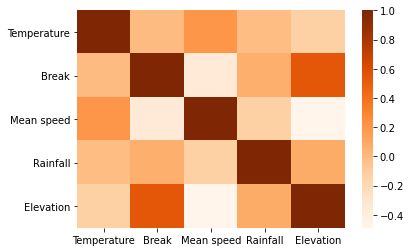

In [1330]:
sns.heatmap(df.corr(), cmap='Oranges', annot = False)# load correlation into heatmap
plt.savefig('heatmap.svg')# export svg 
plt.show() #plot figure

The heatmap show us a low correlation between the mean speed (dependent) and other variables (independent). By using a scatterplot matrix we can get a better visualization. 

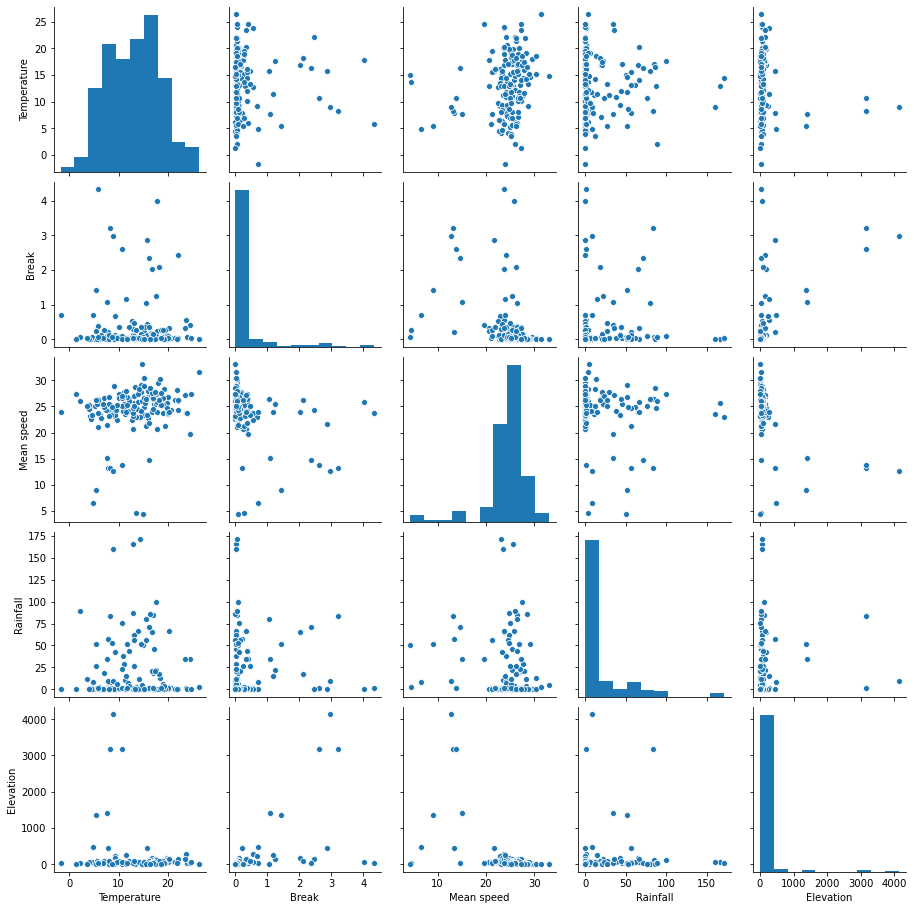

In [1331]:
sns.pairplot(df)
plt.savefig('scatterplot.svg')
plt.show() #using Matplotlib to show the plot

We can note a few things from the matrix:
    
- Break, Rainfall and Elevation are right-skewed (positive skewed). They have a tail on the right.
- Mean speed is left skewed (negative skewed).
- The variables show almost no correlation. Only Break and Elevation show some little correlation. 

In this notebook we predict the Mean speed (a numerical variable). Therefore, the categorical variables need to be converted into numbers. We can convert the variables by using get dummies function.

In [1332]:
df = pd.get_dummies(df)# convert categorical variables into dummies
df.head()

,Temperature,Break,Mean speed,Rainfall,Elevation,Day_Friday,Day_Monday,Day_Saturday,Day_Sunday,Day_Thursday,Day_Tuesday,Day_Wednesday,Weekday/weekend_Weekday,Weekday/weekend_Weekend
0,23.70,0.549722,23.827148,1.0,277.122986,0,0,0,0,0,0,1,1,0
1,15.70,2.856111,21.579832,0.0,439.376007,0,1,0,0,0,0,0,1,0
2,16.85,2.022500,23.845748,65.0,180.727432,0,0,0,0,0,1,0,1,0
3,16.25,0.000000,26.972843,0.0,29.874008,0,1,0,0,0,0,0,1,0
4,19.50,0.038056,25.293008,0.0,79.473732,1,0,0,0,0,0,0,1,0


### Spliting the data 

Before we can fit a model we need to set the X and y. X are our independent variables and y is the dependent value that we want to predict. 

In [1333]:
X = df.loc[:, df.columns != 'Mean speed']# take all column except for Mean speed
y = df['Mean speed']

Now we need to split the data into a training and test set. We will use the training set to fit the model, and use the test set to evaluate the model 

In [1334]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.63, test_size = 0.33, random_state = 100) #split X and y value in training and test set

### Training the Decision Tree model

For the prediction of a numerical variable we need to use a regression model. Therefore, we will be using the decision tree regressor.

In [1335]:
tree = DecisionTreeRegressor()# create the model 
tree = tree.fit(X_train, y_train) # fit the model with training set  

After training the model we can use to model to perform the prediction. 

In [1336]:
y_pred = tree.predict(X_test) # perform prediction 

### Evaluating the model

To see how good the fits (goodness of fit (Gof)) we will calculate the $R^2$ by using the predicted Mean speed. 

In [1337]:
r_squared_test = r2_score(y_test, y_pred) # use r2_score to calculate r_squared
print(f"The r_squared is = {r_squared_test}")

The r_squared is = -0.8240122748060994


This negative $R^2$ means the regression line is worse than using the mean value. In this case, the model doesn't fit the data and the model can't predict any speed values. 

The negative value can be explained by looking at the $R^2$ formula:


$R^2 = 1 - \frac{SS_{Regression}}{SS_{Total}}$

In case of the the Decision Tree model, the $SS_{Regression}$ is higher than the $SS_{Total}$. Therefore, it's better to fit a new model. To first see if there is an actual correlation between the variables we can performe a OLS model.

In [1338]:
X = sm.add_constant(X)
mreg = sm.OLS(y, X).fit()
display(mreg.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Mean speed   R-squared:                       0.298
Model:                            OLS   Adj. R-squared:                  0.250
Method:                 Least Squares   F-statistic:                     6.276
Date:                Fri, 22 Jan 2021   Prob (F-statistic):           5.57e-08
Time:                        00:15:07   Log-Likelihood:                -426.78
No. Observations:                 159   AIC:                             875.6
Df Residuals:                     148   BIC:                             909.3
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      13.4476      0.510     26.377      0.000      12.440      14.455
Temperature                 0.1300      0.055      2.367      0.019       0.021       0.239
Break                      -0.8942      0.485     -1.842      0.067      -1.853       0.065
Rainfall                   -0.0110      0.009     -1.184      0.238      -0.029       0.007
Elevation                  -0.0032      0.001     -4.427      0.000      -0.005      -0.002
Day_Friday                  1.4165      0.747      1.897      0.060      -0.059       2.892
Day_Monday                  1.5186      0.690      2.202      0.029       0.156       2.881
Day_Saturday                1.4500      0.703      2.063      0.041       0.061       2.839
Day_Sunday                  4.5846      0.510      8.991      0.000       3.577       5.592
Day_Thursday                1.3919      0.660      2.108      0.037       0.087       2.697
Day_Tuesday                 0.7086      0.611      1.161      0.248      -0.498       1.915
Day_Wednesday               2.3773      0.722      3.293      0.001       0.951       3.804
Weekday/weekend_Weekday     8.8630      0.392     22.616      0.000       8.089       9.637
Weekday/weekend_Weekend     4.5846      0.510      8.991      0.000       3.577       5.592
==============================================================================
Omnibus:                      136.381   Durbin-Watson:                   1.272
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1691.717
Skew:                          -3.134   Prob(JB):                         0.00
Kurtosis:                      17.699   Cond. No.                     1.27e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.63e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

The OLS model shows us a correlation for each variable against the Mean speed. We can also read a positive $R^2$.

### Training the Random Forest model

Now we use another algorithm model to see if we can fit a better model. This time we will be using the 
Random Forest (RF) regressor. 

For the RF we already created the training and test. N_estimator is the number of trees we use for the model (n=5), and max_features is the size of the random subsets (tree branches) of features to consider when splitting a tree node.

In [1339]:
rf = RandomForestRegressor(n_estimators = 7, max_features = 1.0, random_state=100) #create the model
rf = rf.fit(X_train, y_train) # fit the model 

y_pred = rf.predict(X_test) # perform prediction 

### Evaluating the model 

In [1340]:
r_squared_test = r2_score(y_test, y_pred) #use r2_score to calculate r_squared
print(f"The r_squared is = {r_squared_test}")

The r_squared is = 0.2786377956864783


This model The RF model fits the model poorly. The Gof of the model is 28%. This means the model explains 28% of the varibility of the response data around its mean. Now we have a positive value we can also perform a Mean Squared Error (MSE).  The lower the $MSE$ the better. For the $MSE$ we will be using the following formula:

$MSE = \frac{1}{n} \sum_{n=1}^{n} (y_i − \hat{f}(x_i))$

After calculating the $MSE$ we take the $RMSE$ to see how much the model is off.

In [1346]:
mse = sk.metrics.mean_squared_error(y_test, y_pred) # calulate model fit for the actual y an dpredicted y
rmse = math.sqrt(mse)
print(f"The RMSE is = {rmse}")

The RMSE is = 3.7198552009151107


The $RMSE$ is the absolute fit of the model to the data. With a $RMSE$ of 3.72, we can conclude that the RF model predicts about 3.72 off of the mean speed. 

### Visualizing the best line

In [1342]:
# create dataframe of y_test and y_pred
data = {'Actual Mean speed':  y_test, 
        'Predicted Mean speed': y_pred
        }

df1 = pd.DataFrame (data, columns = ['Actual Mean speed','Predicted Mean speed'])

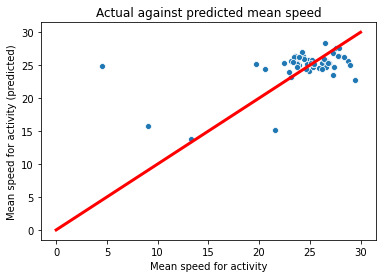

In [1344]:
sns.scatterplot(x='Actual Mean speed',y='Predicted Mean speed',data=df1)
 #Ditto for y-axis. I want both axes to have the same length, so we can compare them
plt.plot([0, 30], [0, 30], color='red', lw=3) #This draws the straight red line, you can leave this out if you wish
plt.title('Actual against predicted mean speed')
plt.xlabel('Mean speed for activity')
plt.ylabel('Mean speed for activity (predicted)')
plt.savefig('predicted.svg')
plt.show()

On the x-axis we see the actual mean speed, and on the y-axis the predicted. We see that the points are not on the line. Therefore, we can conclude that the model predicts too high (overshoots) for low mean speed, and too low (undershoots for high mean spead.

### Conclusion

With a $R^2$ of 0.28 and a $RMSE$ of 3.72 we can conclude that the model has an overall poor fitting. However, we are predicting a variable in a human activity context. Therefore, we are predicting human behavior. This can explain the poor fitting.